In [1]:
# setup notebook if it is run on Google Colab, cwd = notebook file location
try:
    # change notebook_path if this notebook is in a different subfolder of Google Drive
    notebook_path = "Projects/QuantumFlow/notebooks"

    import os
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir("/content/gdrive/My Drive/" + notebook_path)

    %tensorflow_version 2.x
    !pip install -q ruamel.yaml
except:
    pass

# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# setup paths and variables for shared code (../quantumflow) and data (../data)
import sys
sys.path.append('../')
data_dir = "../data"

# import shared code, must run 0_create_shared_project_files.ipynb first!
from quantumflow.generate_datasets import generate_potentials
from quantumflow.numerov_solver import *
from quantumflow.utils import load_hyperparameters, QFDataset, integrate, laplace

# Algortihm Analysis

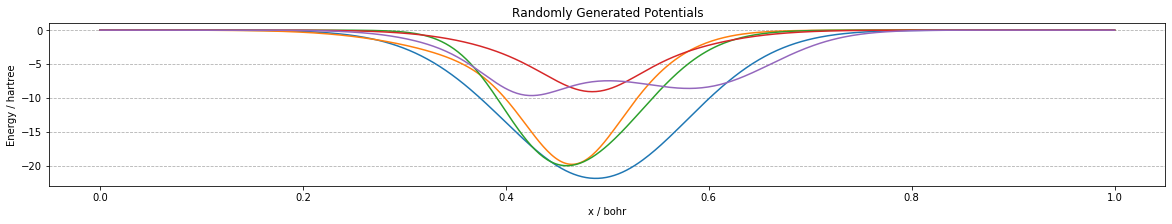

In [2]:
experiment = 'recreate'
analyse_name = "train"


preview = 5
analysis_dataset_size = 100
figsize = (20, 3)
dpi = None

params = load_hyperparameters(os.path.join(data_dir, experiment, "hyperparams.config"), run_name=analyse_name, globals=globals())

params['dataset_size'] = analysis_dataset_size

tf.keras.backend.clear_session()
tf.keras.backend.set_floatx(params['dtype'])
tf.random.set_seed(params['seed'])

potential, x, h = generate_potentials(return_x=True, return_h=True, **params)
params['h'] = h

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(potential)[:, :preview]) # only plot first potentials
plt.title("Randomly Generated Potentials")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

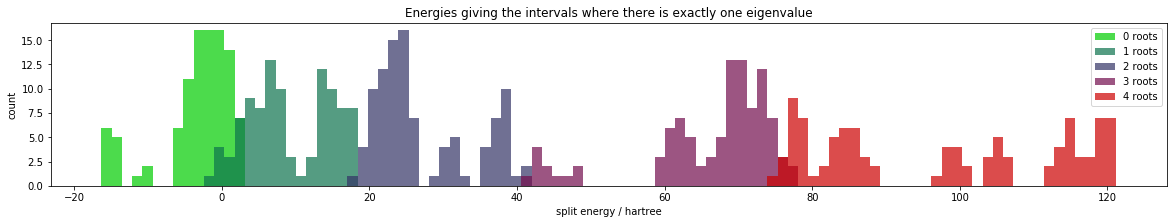

In [3]:
split_energies = find_split_energies(potential, params).numpy()

plt.figure(figsize=figsize, dpi=dpi)
bins = np.linspace(min(split_energies.flatten()), max(split_energies.flatten()), 100)

for i in range(split_energies.shape[1]):
    color = i/(split_energies.shape[1] - 1)
    plt.hist(split_energies[:, i], bins, alpha=0.7, color=[0.8*color**2, 0.8*(1-color)**2, 1.6*color*(1-color)], label= str(i) + " roots")

plt.xlabel('split energy / hartree')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.title("Energies giving the intervals where there is exactly one eigenvalue")
plt.show()

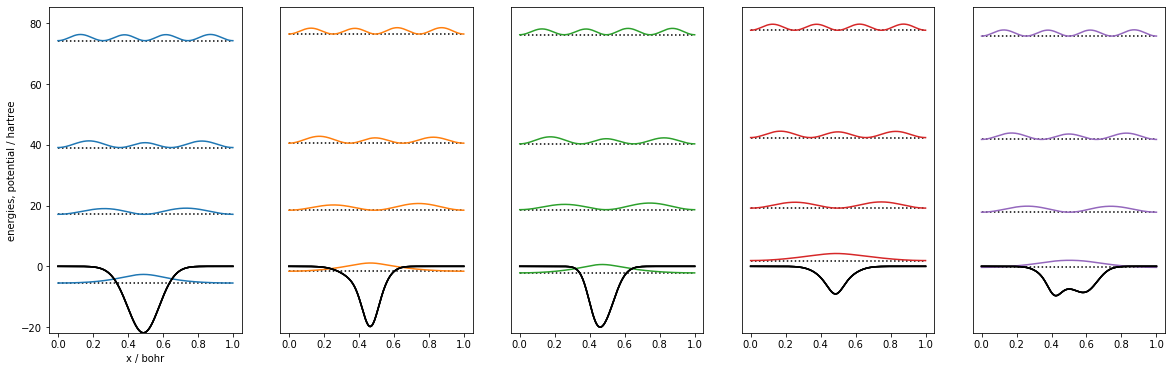

In [4]:
energies, wavefunctions = solve_schroedinger(potential, params)

fig, axs = plt.subplots(1, preview, figsize=(figsize[0], figsize[1]*2), dpi=dpi)

for i, plot in enumerate(wavefunctions.numpy()[:preview]**2 + energies.numpy()[:preview, np.newaxis, :]):
    for n, plot_single in enumerate(plot.transpose()):
        axs[i].plot(x, potential[i], 'k')
        axs[i].plot(x, np.ones(x.shape)*energies[i, n], ':k')
        axs[i].plot(x, plot_single, 'C' + str(i%10))
        axs[i].set_ylim([np.min(potential.numpy()[:preview]), max(np.max(energies.numpy()[:preview]*1.1), 0.5)])
        if i == 0: 
            axs[i].set_ylabel('energies, potential / hartree')
            axs[i].set_xlabel("x / bohr")
        else:
            axs[i].get_yaxis().set_visible(False)
#fig.suptitle('Numerov Solution Energies and Densities')
plt.show()

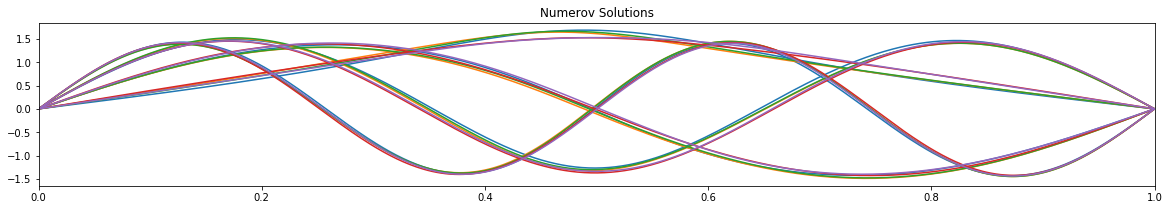

In [5]:
plt.figure(figsize=figsize, dpi=dpi)
for i, plot in enumerate(wavefunctions[:preview]):
    plt.plot(x, plot, 'C' + str(i%10))
plt.xlim(x.numpy()[[0, -1]])
plt.title('Numerov Solutions')
plt.show()

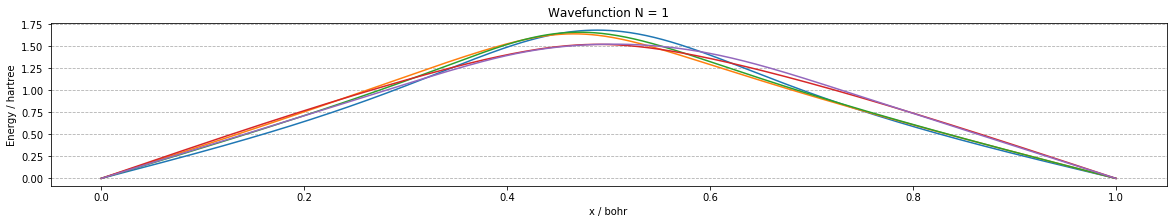

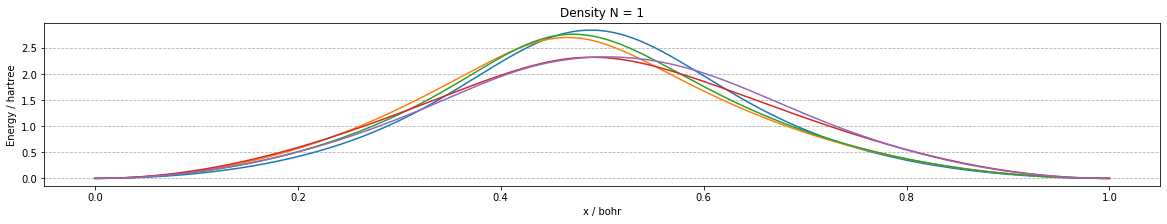

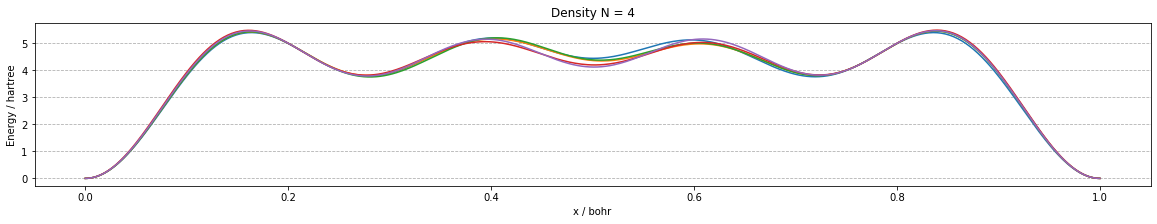

In [6]:
densities = wavefunctions**2
total_density = tf.reduce_sum(densities, axis=2)

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(wavefunctions[:, :, 0])[:, :preview])
plt.title("Wavefunction N = 1")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(densities[:, :, 0])[:, :preview])
plt.title("Density N = 1")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(total_density)[:, :preview])
plt.title("Density N = {}".format(params['n_orbitals']))
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

In [7]:
laplace_wavefunctions = laplace(wavefunctions, params['h'])
kinetic_energy_densities = -0.5*wavefunctions*laplace_wavefunctions

kinetic_energies = integrate(kinetic_energy_densities, params['h'])

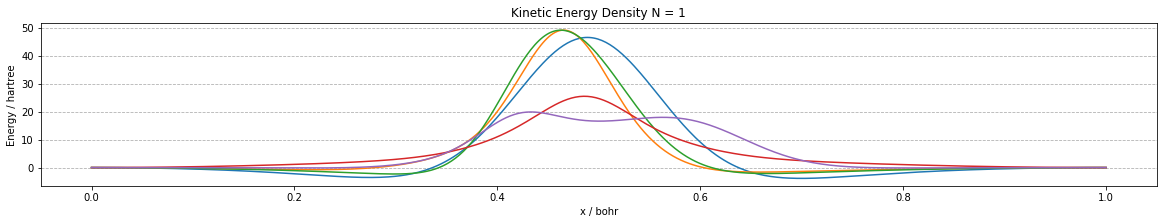

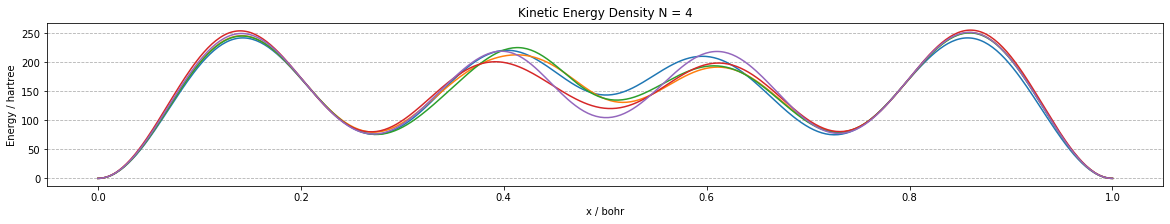

In [8]:
plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(kinetic_energy_densities[:, :, 0])[:, :preview])
plt.title("Kinetic Energy Density N = 1")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(tf.reduce_sum(kinetic_energy_densities, axis=2))[:, :preview])
plt.title("Kinetic Energy Density N = {}".format(params['n_orbitals']))
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

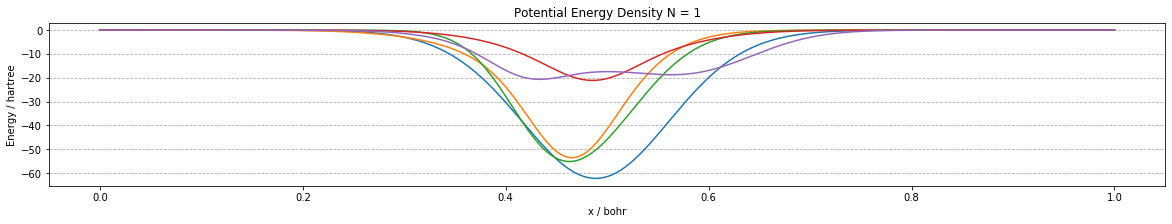

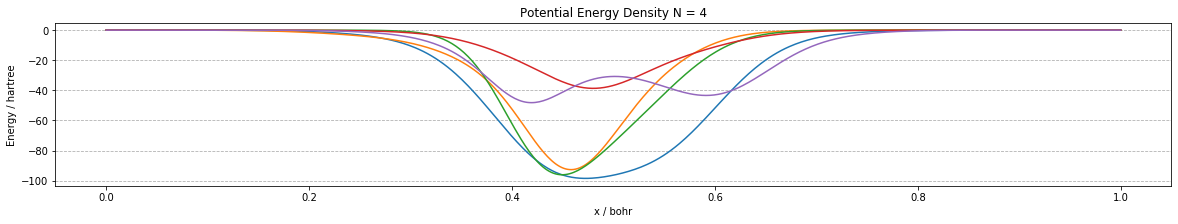

In [9]:
potential_energy_densities = tf.expand_dims(potential, axis=2)*wavefunctions**2
potential_energies = integrate(potential_energy_densities, params['h'])

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(potential_energy_densities[:, :, 0])[:, :preview])
plt.title("Potential Energy Density N = 1")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(tf.reduce_sum(potential_energy_densities, axis=2))[:, :preview])
plt.title("Potential Energy Density N = {}".format(params['n_orbitals']))
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()


N=1 energy:                  [-5.50006566 -1.60318061 -2.15803732  1.90571049 -0.33923046]
N=1 potential energy:        [-11.59809515  -7.29668493  -7.98715865  -3.19450214  -5.52026754]
N=1 kinetic energy:          [6.09796403 5.69345084 5.82906097 5.10018871 5.18101152]
N=1 kinetic energy indirect: [6.09802949 5.69350432 5.82912133 5.10021262 5.18103708]


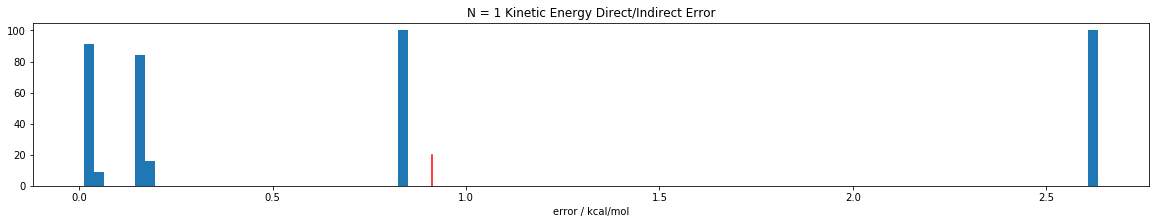

In [10]:
kcalmol_per_hartree = 627.51
kinetic_energies_indirect = energies - potential_energies

print('N=1 energy:                 ', energies[:preview, 0].numpy())
print('N=1 potential energy:       ', potential_energies[:preview, 0].numpy())
print('N=1 kinetic energy:         ', kinetic_energies[:preview, 0].numpy())
print('N=1 kinetic energy indirect:', kinetic_energies_indirect[:preview, 0].numpy())

err = np.abs(kinetic_energies - kinetic_energies_indirect).flatten()*kcalmol_per_hartree
plt.figure(figsize=figsize, dpi=dpi)
plt.hist(err, bins=100)
plt.plot([np.mean(err), np.mean(err)], [0, np.sqrt(params['dataset_size']*params['n_orbitals'])], 'r')
plt.title("N = 1 Kinetic Energy Direct/Indirect Error")
plt.xlabel('error / kcal/mol')
plt.show()

total energy:                  [125.08138402 133.95492183 133.11848695 141.24875316 135.12757571]
total potential energy:        [-23.59661372 -14.46194001 -15.38705368  -6.88442188 -13.05602679]
total kinetic energy direct:   [148.67213626 148.41103479 148.49970063 148.12739235 148.17781089]
total kinetic energy indirect: [148.67799774 148.41686184 148.50554063 148.13317505 148.1836025 ]


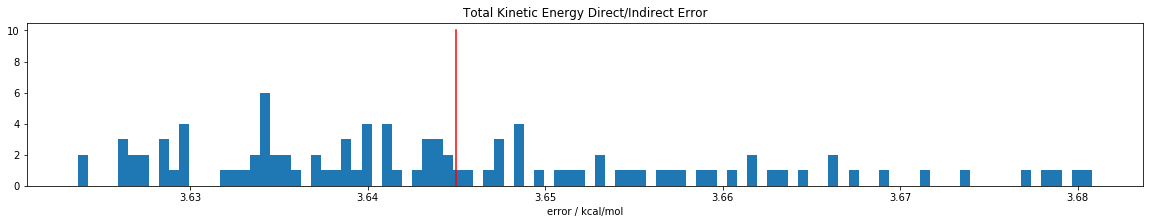

In [11]:
total_energy = tf.reduce_sum(energies, axis=-1)
print('total energy:                 ', total_energy[:preview].numpy())

potential_energy = tf.reduce_sum(potential_energies, axis=-1)
print('total potential energy:       ', potential_energy[:preview].numpy())

kinetic_energy = tf.reduce_sum(kinetic_energies, axis=-1)
print('total kinetic energy direct:  ', kinetic_energy[:preview].numpy())

kinetic_energy_indirect = tf.reduce_sum(kinetic_energies_indirect, axis=-1)
print('total kinetic energy indirect:', kinetic_energy_indirect[:preview].numpy())

err = np.abs(kinetic_energy - kinetic_energy_indirect).flatten()*kcalmol_per_hartree
plt.figure(figsize=figsize, dpi=dpi)
plt.hist(err, bins=100)
plt.plot([np.mean(err), np.mean(err)], [0, np.sqrt(params['dataset_size'])], 'r')
plt.title("Total Kinetic Energy Direct/Indirect Error")
plt.xlabel('error / kcal/mol')
plt.show()

## Direct 5-point stencil method

total kinetic energy 5     : [148.67799797 148.41686211 148.5055409  148.13317536 148.18360278]


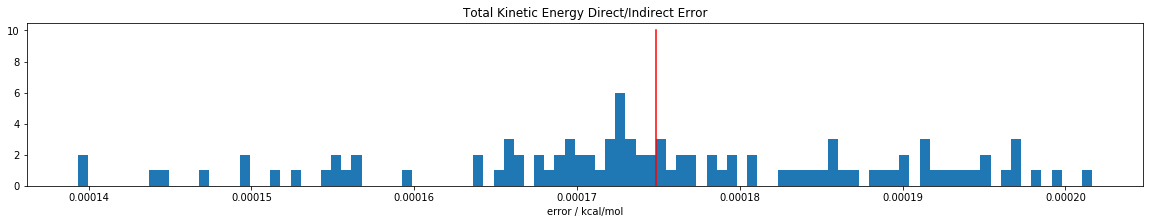

In [12]:
def laplace_5(wavefunctions, h):
    lpwf = 1/(12*h**2)*(-wavefunctions[:, 4:] + 16*wavefunctions[:, 3:-1] - 30*wavefunctions[:, 2:-2] + 16*wavefunctions[:, 1:-3] - wavefunctions[:, 0:-4])
    return tf.concat([3*lpwf[:, 0:1] - 2*lpwf[:, 1:2], 2*lpwf[:, 0:1] - lpwf[:, 1:2], lpwf, 2*lpwf[:, -1:] - lpwf[:, -2:-1], 3*lpwf[:, -1:] - 2*lpwf[:, -2:-1]], axis=1)

laplace_wavefunctions_5 = laplace_5(wavefunctions, params['h'])
kinetic_energy_densities_5 = -0.5*wavefunctions*laplace_wavefunctions_5

kinetic_energies_5 = integrate(kinetic_energy_densities_5, params['h'])

kinetic_energy_5 = tf.reduce_sum(kinetic_energies_5, axis=-1)
print('total kinetic energy 5     :', kinetic_energy_5[:preview].numpy())

err = np.abs(kinetic_energy_indirect - kinetic_energy_5).flatten()*kcalmol_per_hartree
plt.figure(figsize=figsize, dpi=dpi)
plt.hist(err, bins=100)
plt.plot([np.mean(err), np.mean(err)], [0, np.sqrt(params['dataset_size'])], 'r')
plt.title("Total Kinetic Energy Direct/Indirect Error")
plt.xlabel('error / kcal/mol')
plt.show()


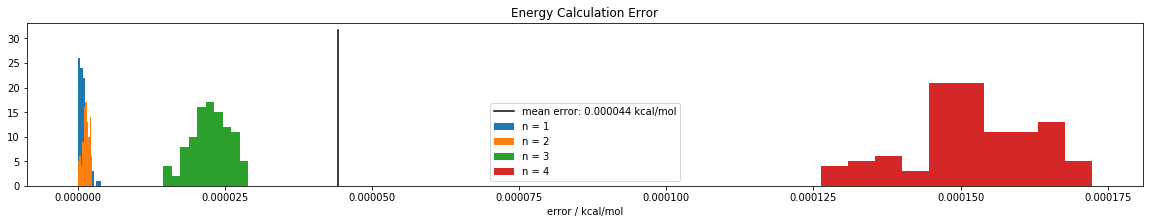

In [13]:
direct_energies = potential_energies + kinetic_energies_5

kcalmol_per_hartree = 627.51
err = np.abs(energies - direct_energies)*kcalmol_per_hartree
plt.figure(figsize=figsize, dpi=dpi)
plt.hist(err[:, 0], bins=10, label='n = 1')
plt.hist(err[:, 1], bins=10, label='n = 2')
plt.hist(err[:, 2], bins=10, label='n = 3')
plt.hist(err[:, 3], bins=10, label='n = 4')
plt.plot([np.mean(err.flatten()), np.mean(err.flatten())], [0, np.sqrt(1000)], 'k' ,label='mean error: {:.06f} kcal/mol'.format(np.mean(err.flatten())))
plt.title("Energy Calculation Error")
plt.xlabel('error / kcal/mol')
plt.legend()
plt.show()

# Numerical Analysis

In [14]:
import h5py

with h5py.File(os.path.join(data_dir, 'recreate/dataset_train.hdf5'), 'r') as f:
    x = f.attrs['x']
    h = f.attrs['h']
    potential = f['potential'][()]
    wavefunctions = f['wavefunctions'][()]
    energies = f['energies'][()]

with h5py.File(os.path.join(data_dir, 'recreate/dataset_fine.hdf5'), 'r') as f:
    x_fine = f.attrs['x']
    h_fine = f.attrs['h']
    potential_fine = f['potential'][()]
    wavefunctions_fine = f['wavefunctions'][()]
    energies_fine = f['energies'][()]


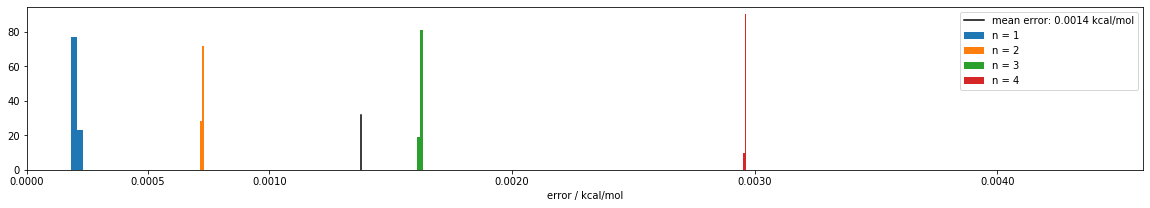

In [15]:
kcalmol_per_hartree = 627.51
err = np.abs(energies - energies_fine)*kcalmol_per_hartree
plt.figure(figsize=figsize, dpi=dpi)
plt.hist(err[:, 0], bins=2, label='n = 1')
plt.hist(err[:, 1], bins=2, label='n = 2')
plt.hist(err[:, 2], bins=2, label='n = 3')
plt.hist(err[:, 3], bins=2, label='n = 4')
plt.plot([np.mean(err.flatten()), np.mean(err.flatten())], [0, np.sqrt(1000)], 'k' ,label='mean error: {:.04f} kcal/mol'.format(np.mean(err.flatten())))
#plt.title("Energy Discretisation Error")
plt.xlabel('error / kcal/mol')
plt.xlim([0, 0.0046])
plt.xticks([0.0, 0.0005, 0.001, 0.002, 0.003, 0.004])
plt.legend()
plt.show()